In [2]:
import numpy as np
import matplotlib.pyplot as plt

## A function which calculates the GC-Skew and returns an array of skew at all positions

In [3]:
def skew(genome):
    skew = np.zeros(len(genome), dtype = np.int)
    i=0
    #loop updates skew values at each position
    for ce in genome:
        #initialization for first position
        if i==0:
            if ce == 'G':
                skew[i] = 1
            elif ce == 'C':
                skew[i] = -1
        #for positions other that 1st, we can calculate using skew value at previous position
        elif ce == 'G':
            skew[i] = skew[i-1] + 1
        elif ce == 'C':
            skew[i] = skew[i-1] - 1
        else:
            skew[i] = skew[i-1]
        i+=1
    return skew

## To get the reverse complement of a dna sequence

In [4]:
def reverse_complement(dna):
    #loop complements each nucleotide in the dna sequence
    for i in range(0,len(dna)):
        if dna[i] == 'A':
            dna = dna[:i] + 'T' + dna[i+1:]
        elif dna[i] == 'T':
            dna = dna[:i] + 'A' + dna[i+1:]
        elif dna[i] == 'C':
            dna = dna[:i] + 'G' + dna[i+1:]
        elif dna[i] == 'G':
            dna = dna[:i] + 'C' + dna[i+1:]
    #return the reverse of the complemented sequence
    return dna[::-1]

## Few functions used in frequency calculation of k-mers in genome

In [5]:
#converts a nucleotide pattern to corresponding index in frequency array
def patternToNumber(seq,k):
    #decode the nucleotides into digits
    seq_numerical = map(decode,seq)
    
    #convert it into an integer
    num = int(reduce(lambda x,y: x+str(y), seq_numerical, ''))
    
    #convert to base 4
    res = 0
    i=0
    while num>0:
        res+=(num%10)*4**i
        num=num/10
        i+=1
    return res

#performs the reverse of function above
def numberToPattern(num,k):
    seq_numerical = []
    i=0
    while num>0:
        x = num % 4
        seq_numerical.append(x)
        num=num/4
    i=len(seq_numerical)
    while i<k:
        seq_numerical.append(0)
        i+=1
    seq_numerical = seq_numerical[::-1]
    seq_numerical = map(encode, seq_numerical)
    seq = reduce(lambda x,y: x+str(y), seq_numerical, '')
    return seq

#maps each of the digit in base 4 to its corresponding nucleotide which are in lexographic order
def encode(x):
    if x == 0:
        x = 'A'
    elif x == 1:
        x = 'C'
    elif x == 2:
        x = 'G'
    elif x == 3:
        x = 'T'
    return x

#maps each of the nucleotide to its corresponding digit in base 4 in lexographic order
def decode(x):
    if x == 'A':
        x = '0'
    elif x == 'C':
        x = '1'
    elif x == 'G':
        x = '2'
    elif x == 'T':
        x = '3'
    return x

## Calculates the number of mismatches between two dna sequences

In [6]:
def hamming_dist(u,v):
    ct=0
    x=0
    while x<len(u):
        if u[x] != v[x]:
            ct+=1
        x+=1
    return ct

### Function which returns a set of patterns which are within 'd' hamming-distance of a pattern

In [7]:
def neighbours(pattern,d):
    if d == 0:
        return {pattern}
    elif len(pattern) == 1:
        return {'A','C','G','T'}
    res = set()
    
    #use recursion to get the neighbours of smaller patterns
    suffix_neighbours = neighbours(pattern[1:],d)
    
    #use these neighbours to calculate the neighbours of current pattern
    for sn in suffix_neighbours:
        if hamming_dist(sn,pattern[1:]) < d:
                res.add('A'+sn)
                res.add('C'+sn)
                res.add('G'+sn)
                res.add('T'+sn)
        else:
            res.add(pattern[0]+sn)
    return res

### Returns the frequency array of k-mers; frequency inlcudes neighbours(within d mismatches) and also includes the reverse complements in the frequency

In [8]:
def freqWithMismatch(genome,k,d):
    freq = np.zeros(4**k,dtype=np.int)
    
    #loop through all k-mers present in the genome
    i=0
    while i<=len(genome)-k:
        cp = genome[i:i+k] #the pattern that is actually present
        cp_rc = reverse_complement(cp) #including the reverse_complement of the pattern
        
        #Also including the nbrs of both the pattern and its reverse complement
        nbr = neighbours(cp,d)
        nbrc = neighbours(cp_rc,d)
        
        #incrementing frequencies of all the patterns selected above
        for cn in nbr:
            index = patternToNumber(cn,k)
            freq[index]+=1
        for cn in nbrc:
            index = patternToNumber(cn,k)
            freq[index]+=1
        i+=1
    return freq

## Reading the genome and removing any NaN,noise and garbage values from the data

In [9]:
f = open("Salmonella_enterica.txt")
genome = f.read()
genome = [x for x in genome if x in ['A','C','G','T']]
genome = ''.join(str(e) for e in genome)

## Plotting the skew and calculating the position which minimizes the skew

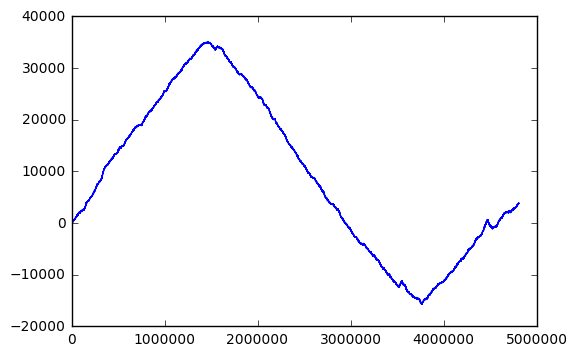

In [10]:
skew = skew(genome)
plt.plot(skew)
plt.show()
min_indices = np.where(skew == skew.min())

## The ori is believed to be within 1000 positions of the minimum skew position

In [11]:
min_index = int(min_indices[0][0]) - 500
ori = genome[min_index:min_index+1000]

## We consider DnaA boxes to be 9-mers and also within 1 mismatch

In [12]:
k=9
d=1

### From the frequency array we calculate the most frequent k-mers within d mismatches in the ori. These most frequent k-mers are possible DnaA boxes for the genome where replication begins

In [16]:
freq = freqWithMismatch(ori,k,d)
maxFreq = 0
for i in freq:
    if i>= maxFreq:
        maxFreq = i
x=0
ct=0
DnaA = []
#print the k-mers which are most frequent and thus are possible DnaA boxes
for i in freq:
    if i == maxFreq:
        DnaA.append(numberToPattern(x,k))
        ct+=1
    x+=1
for cd in DnaA:
    print cd,

TGTGGATAA TTATCCACA
